# HSCT clustered linear regression model

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Figure out if we are in a Kaggle notebook or not based on the current
# path and set file paths accordingly
if os.getcwd() == '/kaggle/working':
    print('Running on Kaggle')
    training_features_file='/kaggle/input/hsct-survival-polynomial-regression/polynomial_training_features_df.parquet'
    training_labels_file='/kaggle/input/hsct-regression/training_labels_df.parquet'
    data_dictionary_file='/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv'
    model_file='/kaggle/input/hsct-survival-polynomial-regression/03.2-linear_regression_polynomial_features.pkl'
    polynomial_transformer_file='/kaggle/input/hsct-survival-polynomial-regression/03-poly_features_transformer.pkl'
    knn_imputer_file='/kaggle/input/hsct-regression/02-KNN_imputer.pkl'
    one_hot_encoder_file='/kaggle/input/hsct-regression/02-one_hot_encoder.pkl'
    testing_data_file='/kaggle/input/equity-post-HCT-survival-predictions/test.csv'
    submission_file='submission.csv'

else:
    training_features_file='../../data/processed/training_features_df.parquet'
    training_labels_file='../../data/processed/training_labels_df.parquet'
    data_dictionary_file='../../data/raw/data_dictionary.csv'
    model_file='../../models/03.1-linear_regression.pkl'
    # polynomial_transformer_file='../../models/03-poly_features_transformer.pkl'
    knn_imputer_file='../../models/02-KNN_imputer.pkl'
    one_hot_encoder_file='../../models/02-one_hot_encoder.pkl'
    testing_data_file='../../data/raw/test.csv'
    # submission_file='../predictions/polynomial_regression_submission.csv'

## 1. Load data

Features: (28800, 178)
Labels: (28800, 2)


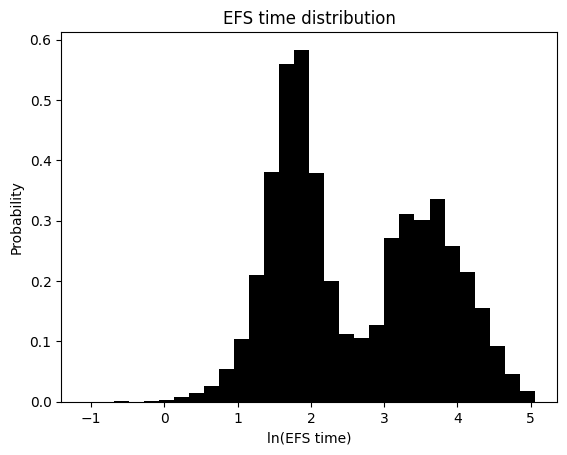

In [2]:
# Load the datasets
features_df=pd.read_parquet(training_features_file)
labels_df=pd.read_parquet(training_labels_file)

# Remove id column from training features
features_df.drop('ID', axis=1, inplace=True)

# Take the log of the labels
labels_df['efs_time']=np.log(labels_df['efs_time'])

print(f'Features: {features_df.shape}')
print(f'Labels: {labels_df.shape}')

plt.title('EFS time distribution')
plt.hist(labels_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('ln(EFS time)')
plt.ylabel('Probability')
plt.show()

## 2. Make naive linear regression predictions

In [3]:
# Load the baseline linear regression model
with open(model_file, 'rb') as input_file:
    regression_model=pickle.load(input_file)

# Make predictions for the whole training set
predictions=regression_model.predict(features_df)

predictions_df=pd.DataFrame.from_dict({
    'EFS time': labels_df['efs_time'],
    'Predicted EFS time': predictions
})

## 3. Cluster predictions

In [4]:
kmeans=KMeans(n_clusters=2, random_state=0, n_init="auto").fit(predictions_df)
predictions_df['Cluster']=kmeans.labels_

## 4. Plot

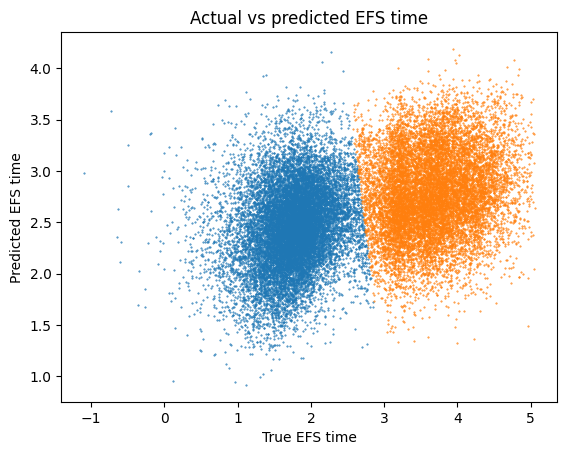

In [5]:
cluster_one=predictions_df[predictions_df['Cluster'] == 0]
cluster_two=predictions_df[predictions_df['Cluster'] == 1]

plt.title('Actual vs predicted EFS time')
plt.scatter(cluster_one['EFS time'], cluster_one['Predicted EFS time'], s=0.2)
plt.scatter(cluster_two['EFS time'], cluster_two['Predicted EFS time'], s=0.2)
plt.xlabel('True EFS time')
plt.ylabel('Predicted EFS time')
plt.show()

## 3. Regression in clusters

### 3.1. Split data by regression clusters

In [6]:
features_df['cluster']=predictions_df['Cluster']
labels_df['cluster']=predictions_df['Cluster']

clustered_features={
    'cluster_one': features_df[features_df['cluster'] == 0],
    'cluster_two': features_df[features_df['cluster'] == 1]
}

clustered_labels={
    'cluster_one': labels_df[labels_df['cluster'] == 0],
    'cluster_two': labels_df[labels_df['cluster'] == 1]
}

### 3.2. Cluster regression

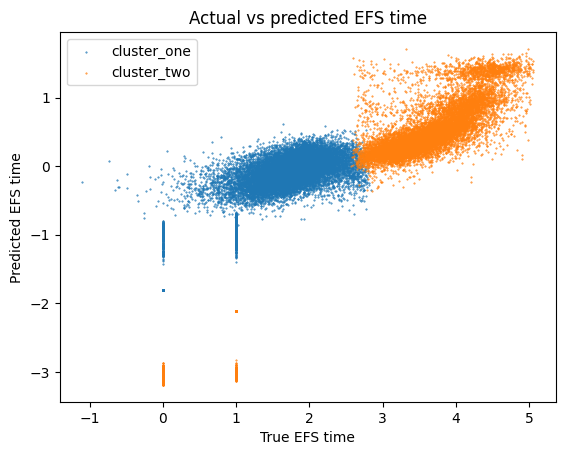

In [7]:
models={
    'cluster_one': LinearRegression(),
    'cluster_two': LinearRegression()
}

for cluster in clustered_features.keys():
    models[cluster].fit(clustered_features[cluster], clustered_labels[cluster])

predictions={}

for cluster in clustered_features.keys():
    cluster_predictions=models[cluster].predict(clustered_features[cluster])
    predictions[cluster]=cluster_predictions - np.mean(cluster_predictions) * 2


plt.title('Actual vs predicted EFS time')

for cluster in clustered_features.keys():
    plt.scatter(clustered_labels[cluster], predictions[cluster], s=0.2, label=cluster)

plt.xlabel('True EFS time')
plt.ylabel('Predicted EFS time')
plt.legend(loc='best')
plt.show()

## 6. Make testing set predictions

### 3.1. Load test data & assets

In [8]:
# Load the one-hot encoder
with open(one_hot_encoder_file, 'rb') as input_file:
    encoder=pickle.load(input_file)

# Load the KNN imputer
with open(knn_imputer_file, 'rb') as input_file:
    imputer=pickle.load(input_file)

# Load testing data and column definitions
testing_data=pd.read_csv(testing_data_file)
data_dictionary=pd.read_csv(data_dictionary_file)

# Save the ID and drop
testing_ids=testing_data['ID']
testing_data.drop('ID', axis=1, inplace=True)
print(f'Testing features: {testing_data.shape}')

Testing features: (3, 57)


### 3.2. Split numeric and categorical features

In [9]:
# Get lists of categorical and numerical column names
categorical_feature_names=data_dictionary['variable'][data_dictionary['type'] == 'Categorical']
numerical_feature_names=data_dictionary['variable'][data_dictionary['type'] == 'Numerical']

# Remove the feature column from the column names lists
categorical_feature_names=categorical_feature_names[categorical_feature_names != 'efs']
numerical_feature_names=numerical_feature_names[numerical_feature_names != 'efs_time']

# Split the testing dataframe
testing_categorical_df=testing_data[categorical_feature_names].copy()
testing_numerical_df=testing_data[numerical_feature_names].copy()

print(f'Testing numerical features: {testing_numerical_df.shape}')
print(f'Testing categorical features: {testing_categorical_df.shape}')

Testing numerical features: (3, 22)
Testing categorical features: (3, 35)


### 3.3. Handle missing data

#### 3.3.1. Categorical features

In [10]:
# Replace NAN with 'Missing' string
testing_categorical_df.fillna('Missing', inplace=True)
print(f'Testing categorical features: {testing_categorical_df.shape}')

Testing categorical features: (3, 35)


#### 3.3.2. Numerical features

In [11]:
# Fill missing data
testing_numerical_data=imputer.transform(testing_numerical_df)

# Re-build dataframe
testing_numerical_df=pd.DataFrame(testing_numerical_data, columns=testing_numerical_df.columns)
print(f'Testing numerical features: {testing_numerical_df.shape}')

Testing numerical features: (3, 22)


### 3.4. One-hot encode categorical features

In [12]:
# Encode the features
testing_categorical_data=encoder.transform(testing_categorical_df)

# Rebuild the dataframe
feature_names=encoder.get_feature_names_out()
testing_categorical_df=pd.DataFrame(testing_categorical_data, columns=feature_names)
print(f'Testing categorical features: {testing_categorical_df.shape}')

Testing categorical features: (3, 156)


### 3.5. Recombine numerical and categorical features

In [13]:
testing_features_df=pd.concat(
    [
        testing_numerical_df.reset_index(drop=True), 
        testing_categorical_df.reset_index(drop=True)
    ],
    axis=1
)

print(f'Testing features: {testing_features_df.shape}')

Testing features: (3, 178)


### 3.6. Make naive linear regression predictions

In [14]:
# Load the baseline linear regression model
with open(model_file, 'rb') as input_file:
    regression_model=pickle.load(input_file)

# Make predictions for testing
predictions=regression_model.predict(testing_features_df)

predictions_df=pd.DataFrame.from_dict({
    'Predicted EFS time': predictions
})

### 3.7 Cluster testing data

In [15]:
kmeans.predict(predictions_df)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- EFS time


In [ ]:
predicted_efs_time=model.predict(testing_data)
scaler=MinMaxScaler()
scaler.fit(predicted_efs_time.reshape(-1, 1))
predicted_efs_time=scaler.transform(predicted_efs_time.reshape(-1, 1))

predictions_df=pd.DataFrame.from_dict({'ID': testing_ids, 'prediction': predicted_efs_time.flatten()})
predictions_df.describe()

In [ ]:
predictions_df.to_csv(submission_file, index=False)